In [1]:
import glob
import os
import scipy
import pathlib
from typing import List, Tuple

from IPython.display import display, HTML
from PIL import Image
from loguru import logger
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import trimesh
from src.utils.load import load_game_state


def load_sample_file(
    sample_file_path_pair: Tuple[pathlib.Path, pathlib.Path]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Loads the JPEG and corresponding binary file from the specified sample file path,
    and returns the loaded images as NumPy arrays.
    """
    jpeg_file, binary_file = sample_file_path_pair
    jpeg_image = np.array(Image.open(jpeg_file))
    game_state = load_game_state(binary_file)
    return jpeg_image, game_state


def get_sample_file_paths(directory: str) -> List[Tuple[pathlib.Path, pathlib.Path]]:
    """
    Finds all the JPEG and corresponding binary files in the specified directory,
    and returns a list of tuples containing the file paths.
    """
    jpeg_files = list(pathlib.Path(directory).glob("*.jpeg"))
    jpeg_files.sort(key=lambda path: int(path.stem))

    sample_file_paths = []
    for jpeg_file in jpeg_files:
        binary_file = jpeg_file.with_suffix(".bin")
        if binary_file.exists():
            sample_file_paths.append((jpeg_file, binary_file))
        else:
            logger.warning(
                f"Could not find corresponding .bin file for {jpeg_file}. Skipping file."
            )

    return sample_file_paths


In [2]:
if __name__ == "__main__":
    """
    ffmpeg -r 60 -i foo_%01d.png -vcodec libx264 -crf 20 -s 800x800 -pix_fmt yuv420p -y movie.mp4

    TODO(adrian): this workflow is slow, but it is probably best kept to jupyter notebook
    TODO(adrian): make a branch and move onto cleaning up this data so that for i'th timestep, we can generate groundtruth data, metrics, track boundaries etc.
    TODO(adrian): parse track data into a cleaned format where it's much faster to parallelise
    """
    import copy
    from src.track_gen.track_gen import Monza

    track = Monza('../../tracks/monza/physics_mesh_object_groups.obj')
    if len(track.group_names) > 0:
        logger.success(f"Loaded: {track.group_names}")
    else:
        raise FileNotFoundError("No meshes loaded")

    recording_path = "../../recordings/monza_audi_r8_lms_1"
    sample_file_paths = get_sample_file_paths(recording_path)

    # Extract relevant data from state dictionary at each time step
    positions_data = []

    for sample in sample_file_paths:
        img, state = load_sample_file(sample)
        x, y, z = (
            state["ego_location_x"],
            state["ego_location_y"],
            state["ego_location_z"],
        )
        positions_data.append([x, y, z])

2023-02-23 20:14:56.818 | SUCCESS  | __main__:<module>:14 - Loaded: {'illconc', 'pitsmnz', 'kerb', 'curb', 'asph', 'penasphd', 'cncou', 'out', 'pencncd', 'sand', 'wall', 'carpet', 'pengrsd', 'grill', 'grass', 'road', 'penaspha', 'pencnca', 'pengrsb', 'tarmou', 'penasphb', 'penasphc', 'concrete'}


In [10]:
# !conda install -c conda-forge shapely -y

In [11]:
'''
Copyright (C) 2018  Andre Lester Kruger
ConcaveHull.py is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 2 of the License, or
(at your option) any later version.
ConcaveHull.py is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with ConcaveHull.py.  If not, see <http://www.gnu.org/licenses/>.
'''

import bisect
from collections import OrderedDict
import math
#import numpy as np
import matplotlib.tri as tri
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.ops import linemerge


class ConcaveHull:
    def __init__(self):
        self.triangles = {}
        self.crs = {}
        
    
    def loadpoints(self, points):
        #self.points = np.array(points)
        self.points = points
        
        
    def edge(self, key, triangle):
        '''Calculate the length of the triangle's outside edge
        and returns the [length, key]'''
        pos = triangle[1].index(-1)
        if pos==0:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][1]]
        elif pos==1:
            x1, y1 = self.points[triangle[0][1]]
            x2, y2 = self.points[triangle[0][2]]
        elif pos==2:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][2]]
        length = ((x1-x2)**2+(y1-y2)**2)**0.5
        rec = [length, key]
        return rec
        
    
    def triangulate(self):
        
        if len(self.points) < 2:
            raise Exception('CountError: You need at least 3 points to Triangulate')
        
        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del(temp)
        
        triang = tri.Triangulation(x, y)
        
        self.triangles = {}
        
        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
        

    def calculatehull(self, tol=50):
        
        self.tol = tol
        
        if len(self.triangles) == 0:
            self.triangulate()
        
        # All triangles with one boundary longer than the tolerance (self.tol)
        # is added to a sorted deletion list.
        # The list is kept sorted from according to the boundary edge's length
        # using bisect        
        deletion = []    
        self.boundary_vertices = set()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])
            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self.edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
        while len(deletion) != 0:
            # The triangles with the longest boundary edges will be 
            # deleted first
            item = deletion.pop()
            ref = item[1]
            flag = 0
            
            # Triangle will not be deleted if it already has two boundary edges            
            if self.triangles[ref][1].count(-1) > 1:
                continue
                
            # Triangle will not be deleted if the inside node which is not
            # on this triangle's boundary is already on the boundary of 
            # another triangle
            adjust = {0: 2, 1: 0, 2: 1}            
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue
           
            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self.edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)
                                        
            del self.triangles[ref]
            
        self.polygon()
            
                    

    def polygon(self):
        
        edgelines = []
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos==0:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][1]]
                        elif pos==1:
                            x1, y1 = self.points[triangle[0][1]]
                            x2, y2 = self.points[triangle[0][2]]
                        elif pos==2:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][2]]
                        line = LineString([(x1, y1), (x2, y2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)
    
        self.boundary = Polygon(bound.coords)

0.0
0.00010757314974182444
0.0002151462994836489
0.00032271944922547335
0.0004302925989672978
0.0005378657487091222
0.0006454388984509467
0.0007530120481927711
0.0008605851979345956
0.00096815834767642
0.0010757314974182443
0.0011833046471600688
0.0012908777969018934
0.0013984509466437177
0.0015060240963855422
0.0016135972461273666
0.0017211703958691911
0.0018287435456110154
0.00193631669535284
0.0020438898450946645
0.0021514629948364886
0.002259036144578313
0.0023666092943201377
0.0024741824440619622
0.0025817555938037868
0.002689328743545611
0.0027969018932874354
0.00290447504302926
0.0030120481927710845
0.0031196213425129086
0.003227194492254733
0.0033347676419965577
0.0034423407917383822
0.0035499139414802068
0.003657487091222031
0.0037650602409638554
0.00387263339070568
0.0039802065404475045
0.004087779690189329
0.0041953528399311536
0.004302925989672977
0.004410499139414802
0.004518072289156626
0.004625645438898451
0.004733218588640275
0.0048407917383821
0.0049483648881239245
0.0

KeyboardInterrupt: 

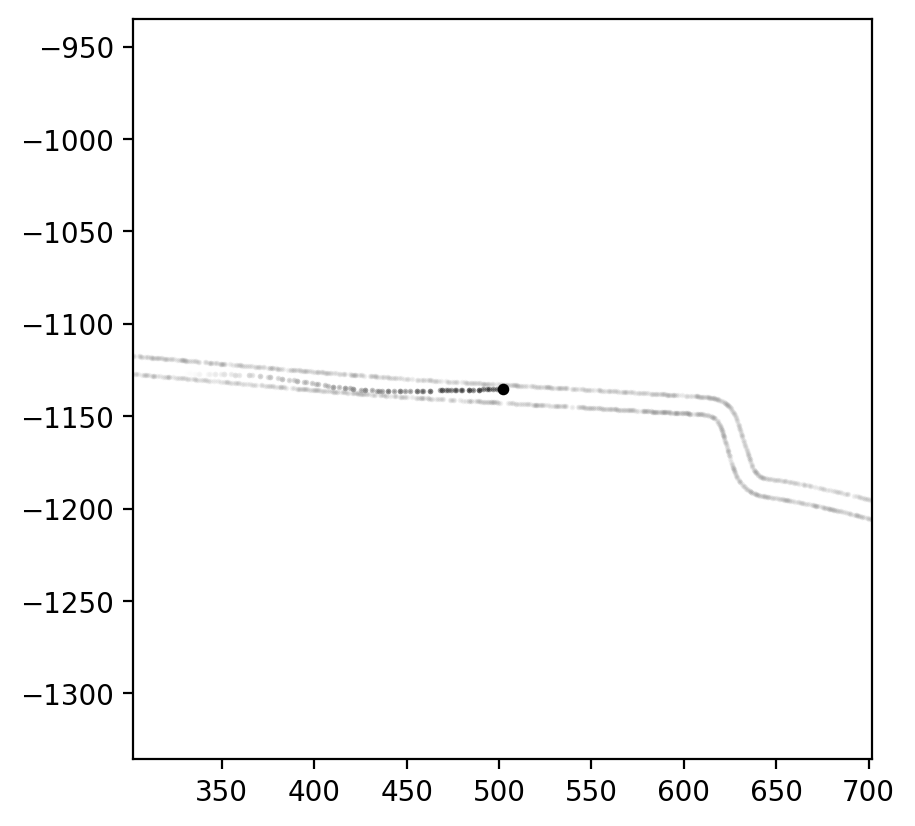

In [77]:
# Set up the figure and axis
def gen_frame(i, positions, track, track_vertices) -> None:
    # i, positions, track = dic.get("i"), dic.get("positions"), dic.get("track")
    fig, ax = plt.subplots(dpi=200)
    ax.set_aspect("equal")

    x, y, z = positions[i]

    # Select the last 60 positions
    historical_positions = positions[max(0, i - (30 * 3)) : i]

    # Select the future positions, up to the next 60
    future_positions = positions[i + 1 : min(len(positions), i + (30 * 3) + 1)]

    # Concatenate historical and future positions

    if len(historical_positions) > 0 and len(future_positions) > 0:
        historical_and_future_positions = np.concatenate(
            [historical_positions, future_positions], axis=0
        )

    elif len(future_positions) == 0:
        historical_and_future_positions = historical_positions
    else:
        historical_and_future_positions = future_positions

    # Select the x and z coordinates
    trajectory = np.arange(len(historical_and_future_positions))[:, np.newaxis]
    trajectory = np.hstack([trajectory, trajectory])
    
    ax.scatter(
        track_vertices[:, 0],
        track_vertices[:, 2],
        color="gray",
        s=1,
        alpha=0.1,
        label="track",
    )

    # Draw the dots for the historical positions
    for j in range(len(historical_positions)):
        _x, _, _z = historical_positions[j]
        ax.scatter(
            _x,
            _z,
            color=plt.cm.get_cmap("gray")(np.linspace(1, 0, len(historical_positions)))[
                j
            ],
            s=1,
            alpha=0.4,
        )

    # Draw the solid dot for the current position
    ax.scatter(x, z, color="black", s=10)

    # Set the camera view to show anything within 50 units of the current position
    # ax.set_xlim([500, 1100])
    # ax.set_ylim([-750, -1300])
    ax.set_xlim([x - 200, x + 200])
    ax.set_ylim([z - 200, z + 200])
    plt.savefig(f"../../src/analysis/imgs/foo_{i}.png", bbox_inches="tight")
    # plt.show()
    plt.close()

    return [f"../../src/analysis/imgs/foo_{i}.png"]

if __name__ == "__main__":
    
    # get track boundaries
    edge_vertices_3d = None
    vertices_to_display = None
    for mesh_id, mesh in track.named_meshes.get("asph").items():
        # an edge which occurs only once is on the boundary        
        unique_edges = mesh.edges[trimesh.grouping.group_rows(mesh.edges_sorted, require_count=1)]
        edge_vertices = mesh.vertices[np.unique(unique_edges.flatten())]
        
        # record the edge track vertices for later recovery of 3d vertices
        if type(vertices_to_display) == type(None):
            edge_vertices_3d = edge_vertices
        else:
            edge_vertices_3d = np.concatenate((edge_vertices_3d, edge_vertices))
        
        # get rid of the points in the middle
        ch = ConcaveHull()
        ch.loadpoints(edge_vertices[:, ::2]) # pulling out x and z
        ch.calculatehull(tol=0.1)
        vertices = np.vstack(ch.boundary.exterior.coords.xy).T  

        # record the sparser track vertices
        if type(vertices_to_display) == type(None):
            vertices_to_display = vertices
        else:
            vertices_to_display = np.concatenate((vertices_to_display, vertices))
            
    # now we can remove the points we drive over because we know they have duplicate vertices in other meshes
    # get rid of the points in the middle
    dists = scipy.spatial.distance.cdist(vertices_to_display, vertices_to_display)
    np.fill_diagonal(dists, np.inf)
    vertices_to_display = vertices_to_display[np.min(dists, axis=1) > 0.3] # 10cm
    
    # we've done all of the calculations in 2d, so to recover the 3d vertices, we can simply find which vertices overlap
    dists = scipy.spatial.distance.cdist(edge_vertices_3d[:, ::2], vertices_to_display)
    np.fill_diagonal(dists, np.inf)
    vertices_to_display = edge_vertices_3d[np.min(dists, axis=1) < 0.01]
    
    for i in range(len(positions_data)):
        print(i/len(positions_data))
        gen_frame(i=i, positions=positions_data, track=track, track_vertices=vertices_to_display)
    
    
    # for i in range(len(positions_data)):
    #     if not os.path.exists(f"src/analysis/imgs/foo_{i}.png"):
    #         gen_frame(i=i, positions=positions_data, track=track)
    #     print(f"{i/len(positions_data)}")